In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget https://raw.githubusercontent.com/ProfAI/natural-language-processing/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv

--2024-02-06 10:35:30--  https://raw.githubusercontent.com/ProfAI/natural-language-processing/main/datasets/Verifica%20Finale%20-%20Spam%20Detection/spam_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5400995 (5.2M) [text/plain]
Saving to: ‘spam_dataset.csv.1’

spam_dataset.csv.1  100%[===================>]   5.15M  20.2MB/s    in 0.3s    

2024-02-06 10:35:32 (20.2 MB/s) - ‘spam_dataset.csv.1’ saved [5400995/5400995]



In [ ]:
!pip install funcy -q
!pip install tzdata -q
!pip install --no-deps pyLDAvis -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.1 MB/s eta 0:00:00


In [636]:
# Visualization and EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# utils & preprocessing
from tqdm import tqdm
from collections import Counter
import re
import string
import warnings

# Classification

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

# Natural Language Processing
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from gensim.models import CoherenceModel,LdaModel
from gensim.corpora import Dictionary
from pprint import pprint
import pyLDAvis.gensim

import spacy
import os
nlp = spacy.load('en_core_web_sm')
!python -m spacy download en_core_web_sm -q

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Ignore DeprecationWarnings
warnings.simplefilter('ignore', category=DeprecationWarning)

# Define a seed for reproducibility
np.random.seed(42)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df = pd.read_csv('spam_dataset.csv')

# FAST PRE EDA CLEANING

- NaN values
- Missing values
- Duplicates
- Useless columns

In [ ]:
df.head(10)

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\nth...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\n( see a...",0
2,3624,ham,"Subject: neon retreat\nho ho ho , we ' re arou...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\nthis deal is to ...,0
5,2949,ham,Subject: ehronline web address change\nthis me...,0
6,2793,ham,Subject: spring savings certificate - take 30 ...,0
7,4185,spam,Subject: looking for medication ? we ` re the ...,1
8,2641,ham,Subject: noms / actual flow for 2 / 26\nwe agr...,0
9,1870,ham,"Subject: nominations for oct . 21 - 23 , 2000\...",0


In [ ]:
# check the shape of the dataset
df.shape

(5171, 4)

In [ ]:
# since Unnamed: 0 is just an index and label_num is the binarized label column, we can drop them
df.drop(['Unnamed: 0', 'label_num'], axis=1, inplace=True)

# switch the label column to the right
df.insert(1, 'label', df.pop('label'))

df.head(10)

,text,label
0,Subject: enron methanol ; meter # : 988291\nth...,ham
1,"Subject: hpl nom for january 9 , 2001\n( see a...",ham
2,"Subject: neon retreat\nho ho ho , we ' re arou...",ham
3,"Subject: photoshop , windows , office . cheap ...",spam
4,Subject: re : indian springs\nthis deal is to ...,ham
5,Subject: ehronline web address change\nthis me...,ham
6,Subject: spring savings certificate - take 30 ...,ham
7,Subject: looking for medication ? we ` re the ...,spam
8,Subject: noms / actual flow for 2 / 26\nwe agr...,ham
9,"Subject: nominations for oct . 21 - 23 , 2000\...",ham


In [ ]:
# All email start with "subject"?
df['text'].str.startswith('Subject').all()

True

In [ ]:
# check for any null,missing, or duplicate values

def scanner(df):
    print(f"Duplicate observations: {df.duplicated().sum()}")
    print(f"Missing values: {df.isnull().sum()}")
    print(f"NaN values: {df.isna().sum()}")

In [ ]:
scanner(df['text'])

Duplicate observations: 178
Missing values: 0
NaN values: 0


In [ ]:
# remove duplicates
df.drop_duplicates(inplace=True)

In [ ]:
# Check the balance of the dataset
df['label'].value_counts()

ham     3531
spam    1462
Name: label, dtype: int64

- ### Any missing/duplicate/NaN values are removed.

*Notice the fact that the dataset is quite imbalanced.
We would check if this imbalance make trouble during classification later.*

# ANALIZE SPAM EMAIL

In [ ]:
spam = df[df['label'] == 'spam']

In [ ]:
# plot 5 random samples from spam
print(spam['text'].sample(5).values)

["Subject: explore really good super viagrma ! : - ) a unshackling vesicopubic taciturnly .\n' ello , ' ello , ' ello , what have we got here ? to speak of morals in art is to speak of legislature in sex . art is the sex of the imagination .\nciali 6 s ( regaligs ) , at cheap prices . most zones charge $ 20 , we charge $ 4 . 95 .\nquite a diffeerence . cialiks is knnown as a super viagraa or weekend viagrxa\nbecause its eetcffs start soneor and last much lgnoer . shipped\nworldwide . your easy - to - use solution is here : http : / / www . medz 4 cheap . com / cia / ? dcent\n- - - - - if you do not wish to be misconjugate = ] fear cannot be without hope nor hope without fear . http : / / www . medz 4 cheap . com / off . htmlwriting criticism is to writing fiction and poetry as hugging the shore is to sailing in the open sea ."
 "Subject: re : mlle joy wilson\ncapitale d ' investissement .\ncher ( es ) honn?te investisseurs ,\nje suis contact?s par une cliente fiable ( mlle joy\nwilson 

In [ ]:
def plot_length_distribution(data, text_column, label_column):
    """
    Plot the distribution of text lengths and boxplot of lengths by label.

    Parameters:
    - data: DataFrame containing the text and label columns
    - text_column: Name of the text column in the DataFrame
    - label_column: Name of the label column in the DataFrame
    """
    # Check the length of the text
    lengths = data[text_column].str.len()
    max_length = lengths.max()

    # Create subplots
    plt.figure(figsize=(12, 6))

    # Subplot 1: Histogram with KDE
    plt.subplot(1, 2, 1)
    sns.set(style="whitegrid")
    sns.histplot(lengths, bins=50, kde=True, color='skyblue', edgecolor='black')
    plt.title('Distribution of Lengths')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(['Length of text', f"Max length: {max_length}"])

    # Subplot 2: Boxplot of lengths by label
    plt.subplot(1, 2, 2)
    sns.boxplot(x=label_column, y=lengths, data=data, palette='Set3', hue=label_column)
    plt.title('Distribution of Lengths by Label')
    plt.xlabel('Label')
    plt.ylabel('Length')

    plt.show()

#


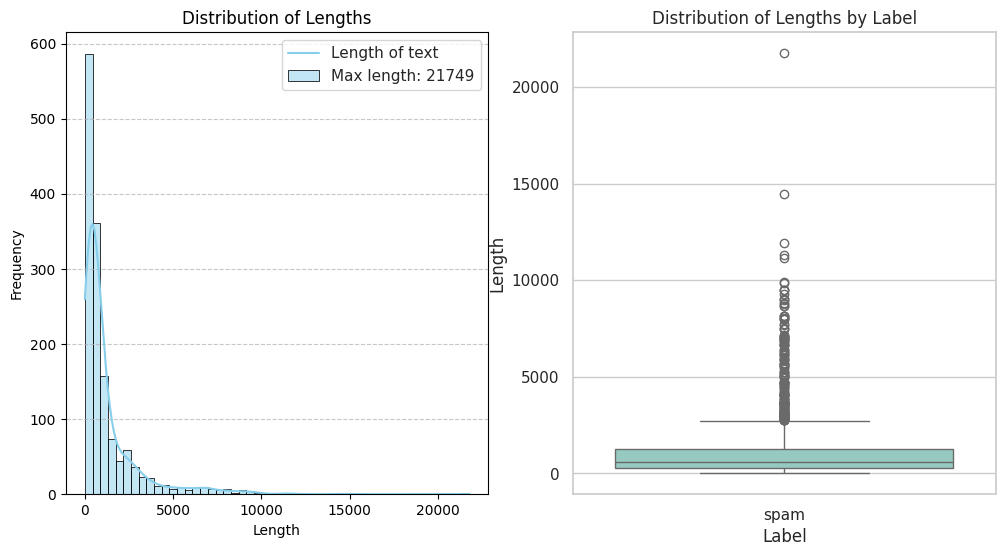

In [ ]:
plot_length_distribution(spam, 'text', 'label')

In [ ]:
# Usually spam email may contain a lot of symbols, with this function we can try to estimate the frequency of each symbol contained
# in the corpus of spam emails.
def calculate_freq_symbols(df,symbols_list):
    """
    Calculate the frequency of each symbol in the text

    Parameters:
    df (pandas.DataFrame): The DataFrame containing the text data
    symbols_list (list): A list of symbols to calculate the frequency of

    Returns:
    dict: A dictionary containing the frequency of each symbol
    """
    symbol_frequency = {}
    # Assuming 'spam' is your DataFrame and 'text' is the column containing text data
    splitted_spam = df.str.split()

    # Count the frequency of each symbol in the text
    symbol_counts = Counter(char for word_list in splitted_spam for word in word_list for char in word if char in spam_symbols)

    # Display the counts
    for symbol, count in symbol_counts.items():
        symbol_frequency[symbol] = count

    # sort the dict
    symbol_frequency = dict(sorted(symbol_frequency.items(), key=lambda item: item[1], reverse=True))
    return symbol_frequency

In [ ]:
# Here a list of symbols that can potentially appear in spam email
symbols = ['$', '#', '!', '%', '&', '*', '@', '<', '>', '[', ']', '(', ')', '{', '}', '|', '/', '\\', '+', '=', '?','_', '-', '^', '~']


In [ ]:
# sort the dict
symbol_frequency = calculate_freq_symbols(spam['text'],symbols)

In [ ]:
def plot_symbol_freq(symbol_frequency):
    """
    Plot the frequency of the symbols
    """
    # plot the frequency of the symbols
    plt.figure(figsize=(12, 6))
    sns.barplot(y=list(symbol_frequency.keys()), x=list(symbol_frequency.values()))
    plt.show()

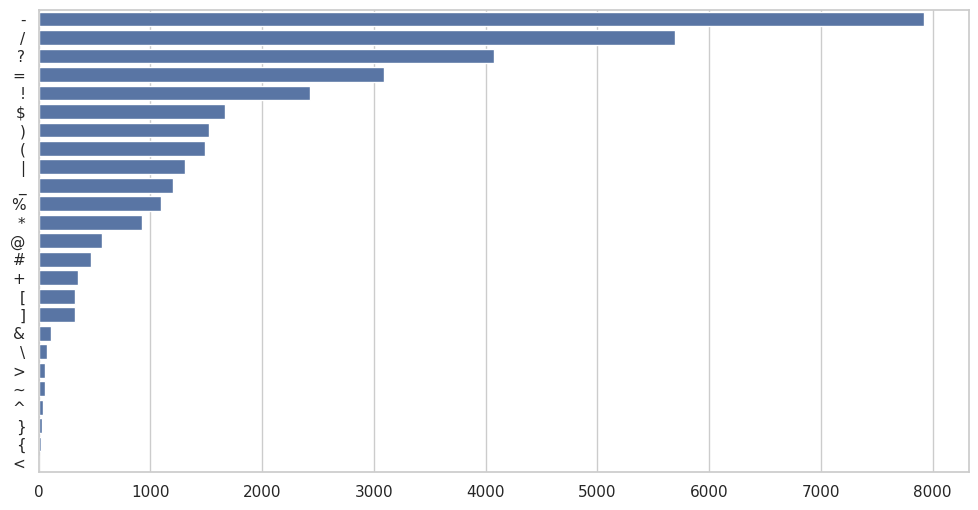

In [ ]:
# plot the frequency of the symbols
plot_symbol_freq(symbol_frequency)

In [ ]:
def calculate_text_stats(text,symbols = None,symbol_frequency = None,to_dict = False):
    """
    Calculate the statistics of the symbols
    """
    if to_dict == False:
        print(f"Max length: {text.str.len().max()}")
        print(f"Min length: {text.str.len().min()}")
        print(f"Mean length: {text.str.len().mean()}")
        print(f"Median length: {text.str.len().median()}")

        # Calculate the total number of symbols
        if symbol_frequency:
            symbol_frequency = calculate_freq_symbols(text,symbols)
            total_symbols = sum(symbol_frequency.values())
            print(f"Total number of symbols: {total_symbols}")

    if to_dict:
        stats_dict = {}
        stats_dict['Max length'] = text.str.len().max()
        stats_dict['Min length'] = text.str.len().min()
        stats_dict['Mean length'] = text.str.len().mean()
        stats_dict['Median length'] = text.str.len().median()
        stats_dict['Total number of symbols'] = total_symbols
        return stats_dict



In [ ]:
calculate_text_stats(spam['text'],symbols, symbol_frequency = True,to_dict=False)

Max length: 21749
Min length: 10
Mean length: 1227.7462380300958
Median length: 577.5
Total number of symbols: 34879


### Report on spam emails:


# PERFORM TOPIC MODELING ON SPAM EMAILS

In [ ]:
def preprocess(text):
    """
    Preprocess the text data
    """
    # Tokenize the text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('english'))

    # Remove 'Subject' from the start of the text
    if tokens and tokens[0] == 'Subject':
        tokens = tokens[1:]

    # Lemmatize the tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Convert to lowercase and remove non-alphabetic tokens and stopwords
    tokens = [token.lower() for token in tokens if token.isalpha() and token not in stop_words]

    # Keep only tokens with length >= 3
    threshold = 3
    tokens = [token for token in tokens if len(token) >= threshold]

    return tokens

In [ ]:

# Initialize an empty list to store preprocessed spam emails
spam_emails = []

# Iterate through each line of text in the 'spam' dataset
for line in tqdm(spam['text'], total=len(spam['text'])):
    # Call the 'preprocess' function to clean and preprocess each line of text
    # Append the preprocessed text to the 'spam_emails' list
    spam_emails.append(preprocess(line))

100%|██████████| 1462/1462 [00:06<00:00, 215.42it/s]


In [ ]:
# Step 1: Create a dictionary object to represent the collection of spam emails.
spam_dictionary = Dictionary(spam_emails)

# Step 2: Convert each email in the spam_emails collection into a Bag-of-Words representation.
spam_corpus = [spam_dictionary.doc2bow(email) for email in spam_emails]

# Step 3: Extract the first document (email) from the dictionary to get its Bag-of-Words representation.
spam_temp = dictionary[0]

# Step 4: Extract a mapping of numerical IDs to tokens (words) from the dictionary.
spam_id2word = spam_dictionary.id2token

# Step 5: Create a Gensim dictionary object from the corpus and the ID-to-word mapping.
gensim_dict = Dictionary.from_corpus(spam_corpus, id2word=id2word)

In [ ]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=2):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(f"Processing: {num_topics} topics")
        model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=10, random_state=42)
        model_list.append(model)
        coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_score = coherence_model.get_coherence()
        print(f"END PROCESSING: {num_topics} topics\nRESULTS:\nCoherence Score: {coherence_score:.2f} for {num_topics} topics\n")
        coherence_values.append(round(coherence_score, 2))
    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=spam_dictionary,
                                                        corpus=spam_corpus,
                                                        texts=spam_emails,
                                                        start=2,
                                                        limit=20,
                                                        step=2)

Processing: 2 topics
END PROCESSING: 2 topics
RESULTS:
Coherence Score: 0.52 for 2 topics

Processing: 4 topics
END PROCESSING: 4 topics
RESULTS:
Coherence Score: 0.66 for 4 topics

Processing: 6 topics
END PROCESSING: 6 topics
RESULTS:
Coherence Score: 0.62 for 6 topics

Processing: 8 topics
END PROCESSING: 8 topics
RESULTS:
Coherence Score: 0.57 for 8 topics

Processing: 10 topics
END PROCESSING: 10 topics
RESULTS:
Coherence Score: 0.55 for 10 topics

Processing: 12 topics
END PROCESSING: 12 topics
RESULTS:
Coherence Score: 0.57 for 12 topics

Processing: 14 topics
END PROCESSING: 14 topics
RESULTS:
Coherence Score: 0.52 for 14 topics

Processing: 16 topics
END PROCESSING: 16 topics
RESULTS:
Coherence Score: 0.57 for 16 topics

Processing: 18 topics
END PROCESSING: 18 topics
RESULTS:
Coherence Score: 0.51 for 18 topics



In [ ]:
coherence_values

[0.52, 0.66, 0.62, 0.57, 0.55, 0.57, 0.52, 0.57, 0.51]

In [ ]:

def plot_coherence_scores(num_topics_list, coherence_values):
    """
    Plot coherence scores against the number of topics.
    Parameters:
    - num_topics_list: List of numbers representing different numbers of topics
    - coherence_values: List of coherence scores corresponding to each number of topics
    """
    plt.figure(figsize=(10, 6))
    # Plotting the results
    plt.plot(num_topics_list, coherence_values, marker='o', linestyle='-', color='b', label='Coherence Score')
    # Customize the plot
    plt.title('Coherence Score vs. Number of Topics', fontsize=16)
    plt.xlabel('Number of Topics', fontsize=14)
    plt.ylabel('Coherence Score', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    # Show the plot
    plt.show()

def generate_num_topics_list(start, end, step):
    """
    Generate a list of numbers representing different numbers of topics.
    Parameters:
    - start: Starting value for the range
    - end: Ending value for the range
    - step: Step size for the range
    Returns:
    - num_topics_list: List of numbers representing different numbers of topics
    """
    return list(range(start, end + step-2, step))

In [ ]:
num_topics = generate_num_topics_list(2, 20, 2)

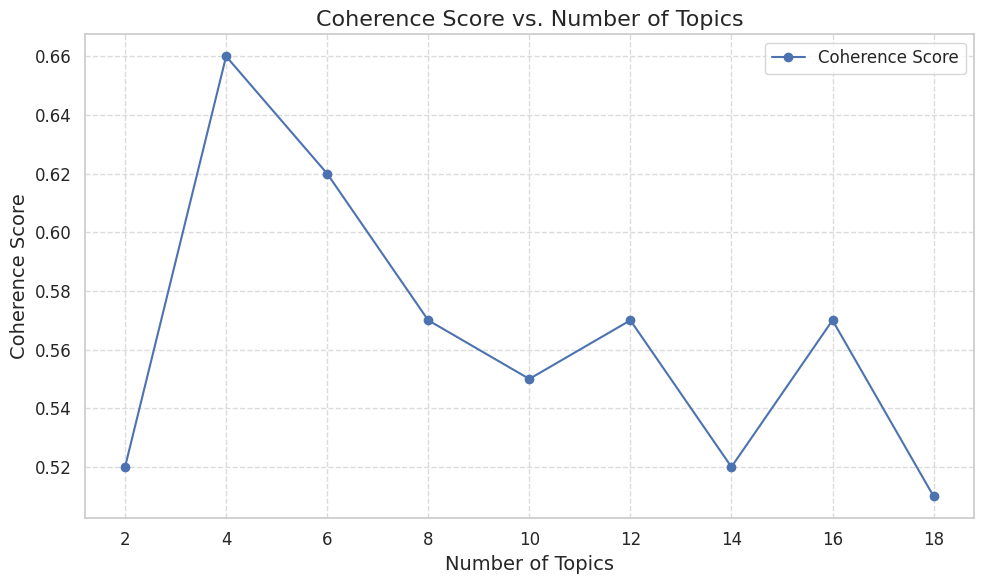

In [ ]:
plot_coherence_scores(num_topics, coherence_values)

In [ ]:
best_spam_coherence = coherence_values.index(max(coherence_values))

In [ ]:
lda_spam_model = model_list[best_spam_coherence]

In [ ]:
model_topic = lda_spam_model.show_topics(formatted=False)
pprint(model_topic)

[(0,
  [('price', 0.0027117862),
   ('get', 0.0024236005),
   ('http', 0.0023757508),
   ('money', 0.0022956082),
   ('please', 0.0022929483),
   ('rate', 0.0022183922),
   ('number', 0.0021765654),
   ('com', 0.0021714186),
   ('email', 0.0020692067),
   ('claim', 0.0020305451)]),
 (1,
  [('font', 0.015210809),
   ('http', 0.013107031),
   ('height', 0.0107915215),
   ('width', 0.00916818),
   ('size', 0.007842749),
   ('align', 0.0069601173),
   ('com', 0.0066110347),
   ('border', 0.005830319),
   ('color', 0.0057317098),
   ('href', 0.0055605294)]),
 (2,
  [('company', 0.011932009),
   ('statement', 0.0068003633),
   ('stock', 0.0063061146),
   ('price', 0.005809849),
   ('information', 0.0050964863),
   ('security', 0.004776845),
   ('may', 0.0045750155),
   ('pill', 0.0043885238),
   ('investment', 0.0041993717),
   ('within', 0.0039037354)]),
 (3,
  [('com', 0.010223058),
   ('http', 0.006958601),
   ('www', 0.0058482364),
   ('nbsp', 0.0053570447),
   ('email', 0.0046409518),
 

In [ ]:
# show topics
pyLDAvis.enable_notebook()
spam_topics_vis = pyLDAvis.gensim.prepare(lda_spam_model, spam_corpus, spam_dictionary)

In [ ]:
spam_topics_vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.167571  0.073001       1        1  38.370854
3     -0.003100 -0.098006       2        1  30.178067
0      0.017742 -0.059955       3        1  17.015470
1      0.152929  0.084960       4        1  14.435609, topic_info=          Term        Freq       Total Category  logprob  loglift
5225      font  372.000000  372.000000  Default  30.0000  30.0000
10780   height  262.000000  262.000000  Default  29.0000  29.0000
66        http  780.000000  780.000000  Default  28.0000  28.0000
167    company  806.000000  806.000000  Default  27.0000  27.0000
2266     width  221.000000  221.000000  Default  26.0000  26.0000
...        ...         ...         ...      ...      ...      ...
1277       www  125.842193  481.052600   Topic4  -5.2499   0.5945
50         com  158.527845  821.791686   Topic4  -5.0190   0.2899
2528      nbsp   76.694039  349.532876   Topic4  -5.7451   0.4187
224        get   62.589549  406.125175   Topic4  -5.9483   0.0654
968       line   52.025689  170.061214   Topic4  -6.1332   0.7511

[303 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
520       1  0.989732  acceptance
816       1  0.572620     account
816       2  0.129650     account
816       3  0.286310     account
816       4  0.010804     account
...     ...       ...         ...
813       1  0.490889        year
813       2  0.293405        year
813       3  0.203126        year
813       4  0.005642        year
1280      2  0.967301   zonedubai

[632 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 4, 1, 2])

# Report on Topic modeling for spam emails:

- Using Latent Dirichlet Allocation (LDA) model, we can find the topics in the spam emails are principally related to:
- **Topic1**: Stock investing
- **Topic2**: Selling stuff
- **Topic3**: Selling,maybe luxury watches (rolex word appear in the text)
- **Topic4**: Seeming to be related to font style or something like that

**Notice how topic 2 and 3 are related to selling something and in fact the semantic distance between them is very low.**

# Explore NON SPAM EMAIL

In [ ]:
ham = df[df['label']=='ham']

In [ ]:
ham

,text,label
0,Subject: enron methanol ; meter # : 988291\nth...,ham
1,"Subject: hpl nom for january 9 , 2001\n( see a...",ham
2,"Subject: neon retreat\nho ho ho , we ' re arou...",ham
4,Subject: re : indian springs\nthis deal is to ...,ham
5,Subject: ehronline web address change\nthis me...,ham
...,...,...
5163,Subject: re : meter # : 1266 ; august 2000 / a...,ham
5165,"Subject: fw : crosstex energy , driscoll ranch...",ham
5166,Subject: put the 10 on the ft\nthe transport v...,ham
5167,Subject: 3 / 4 / 2000 and following noms\nhpl ...,ham


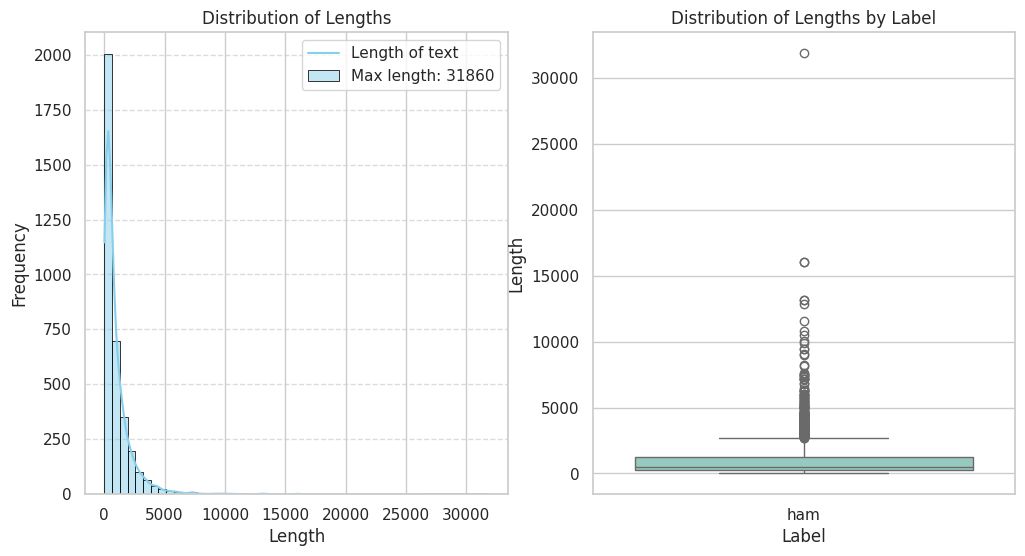

In [ ]:
# Check the lenght of the text
plot_length_distribution(ham, 'text', 'label')

In [ ]:
symbol_ham_freq = calculate_freq_symbols(ham['text'],spam_symbols)

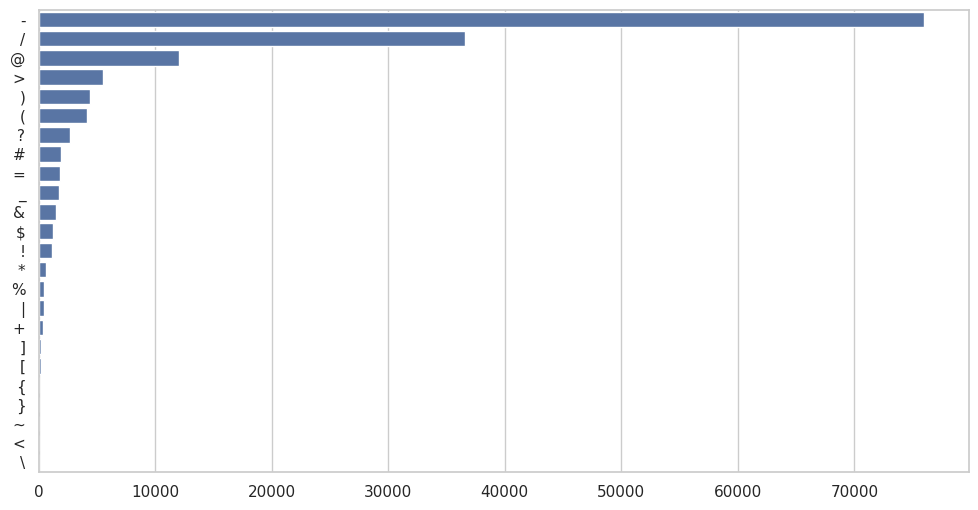

In [ ]:
# plot the frequency of the symbols
plot_symbol_freq(symbol_ham_freq)

In [ ]:
calculate_text_stats(ham['text'],symbols=symbols, symbol_frequency = True,to_dict=False)

Max length: 31860
Min length: 17
Mean length: 977.0897762673463
Median length: 528.0
Total number of symbols: 153307


### Report on HAM emails:

- The statistics of ham emails are quite similar to the statistics of spam emails.
The only difference is that the number of symbols are more frequent in ham emails than spam (but that's probably is due to the fact that the number of ham emails is more than double the spam emails).

#### Make topic modeling on HAM email

In [ ]:
ham_emails = []

for line in tqdm(ham['text'], total=len(ham['text'])):
    ham_emails.append(preprocess(line))

100%|██████████| 3531/3531 [00:11<00:00, 317.58it/s]


In [ ]:
dictionary = Dictionary(ham_emails)

corpus = [dictionary.doc2bow(email) for email in ham_emails]
temp = dictionary[0]

id2word = dictionary.id2token

gensim_dict = Dictionary.from_corpus(corpus, id2word=id2word)

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary,
                                                        corpus=corpus,
                                                        texts=ham_emails,
                                                        start=2,
                                                        limit=20,
                                                        step=2)

Processing: 2 topics
END PROCESSING: 2 topics
RESULTS:
Coherence Score: 0.53 for 2 topics

Processing: 4 topics
END PROCESSING: 4 topics
RESULTS:
Coherence Score: 0.55 for 4 topics

Processing: 6 topics
END PROCESSING: 6 topics
RESULTS:
Coherence Score: 0.50 for 6 topics

Processing: 8 topics
END PROCESSING: 8 topics
RESULTS:
Coherence Score: 0.52 for 8 topics

Processing: 10 topics
END PROCESSING: 10 topics
RESULTS:
Coherence Score: 0.49 for 10 topics

Processing: 12 topics
END PROCESSING: 12 topics
RESULTS:
Coherence Score: 0.51 for 12 topics

Processing: 14 topics
END PROCESSING: 14 topics
RESULTS:
Coherence Score: 0.52 for 14 topics

Processing: 16 topics
END PROCESSING: 16 topics
RESULTS:
Coherence Score: 0.48 for 16 topics

Processing: 18 topics
END PROCESSING: 18 topics
RESULTS:
Coherence Score: 0.50 for 18 topics



In [ ]:
coherence_values

[0.53, 0.55, 0.5, 0.52, 0.49, 0.51, 0.52, 0.48, 0.5]

In [ ]:
num_topics_list = list(range(2, 2 + len(coherence_values) * 2, 2))

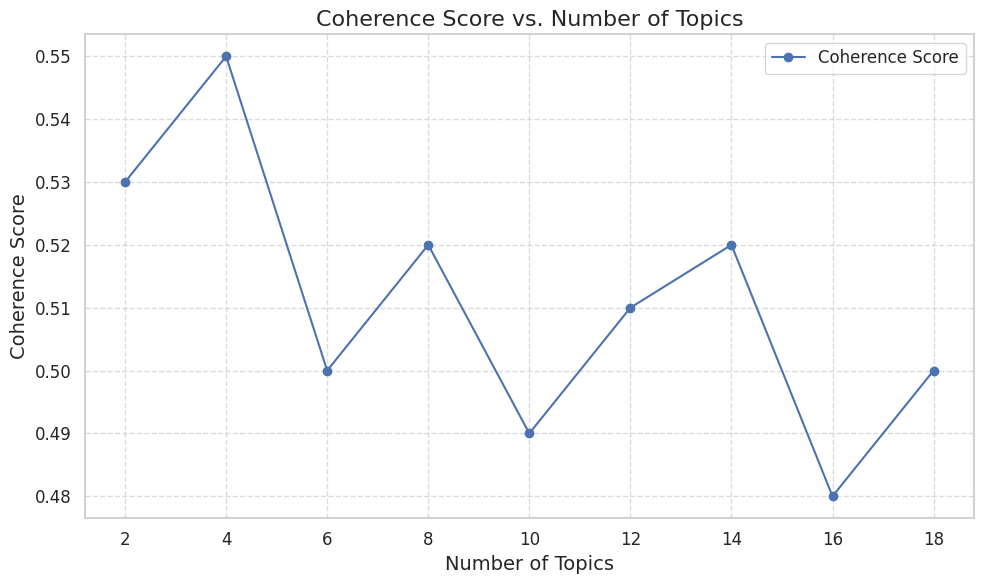

In [ ]:
plot_coherence_scores(num_topics_list, coherence_values)

In [ ]:
best_coherence = coherence_values.index(max(coherence_values))

In [ ]:
lda_model = model_list[best_coherence]

In [ ]:
model_topic = lda_model.show_topics(formatted=False)
pprint(model_topic)

[(0,
  [('ect', 0.13602115),
   ('hou', 0.07121842),
   ('enron', 0.04692798),
   ('subject', 0.014528322),
   ('corp', 0.013862614),
   ('gas', 0.012297508),
   ('hpl', 0.011846199),
   ('forwarded', 0.010843903),
   ('mmbtu', 0.01070182),
   ('meter', 0.008513346)]),
 (1,
  [('deal', 0.03238504),
   ('meter', 0.021617562),
   ('gas', 0.015323388),
   ('daren', 0.014211322),
   ('volume', 0.013840092),
   ('hpl', 0.012275125),
   ('thanks', 0.011367153),
   ('please', 0.010894077),
   ('subject', 0.010891332),
   ('need', 0.010042268)]),
 (2,
  [('com', 0.030227074),
   ('enron', 0.013724239),
   ('mail', 0.007549935),
   ('new', 0.005888247),
   ('net', 0.0056486637),
   ('order', 0.0056363214),
   ('please', 0.005344578),
   ('message', 0.0051381635),
   ('service', 0.004753956),
   ('http', 0.004722925)]),
 (3,
  [('please', 0.012372398),
   ('need', 0.0076104924),
   ('would', 0.007460028),
   ('time', 0.0066198055),
   ('know', 0.006458549),
   ('get', 0.0051605515),
   ('report'

In [ ]:
# show topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

In [ ]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.229890 -0.101686       1        1  31.573051
1     -0.087050  0.141536       2        1  29.377523
3      0.131477  0.067887       3        1  21.065535
2      0.185464 -0.107738       4        1  17.983891, topic_info=        Term          Freq         Total Category  logprob  loglift
389      ect  12838.000000  12838.000000  Default  30.0000  30.0000
411      hou   6742.000000   6742.000000  Default  29.0000  29.0000
182     deal   3406.000000   3406.000000  Default  28.0000  28.0000
55       com   2385.000000   2385.000000  Default  27.0000  27.0000
8      enron   5999.000000   5999.000000  Default  26.0000  26.0000
..       ...           ...           ...      ...      ...      ...
598     sent    131.675358    608.872312   Topic4  -5.9915   0.1844
335  subject    139.529179   2569.343812   Topic4  -5.9335  -1.1974
35       see    129.445573    933.218339   Topic4  -6.0085  -0.2597
477      may    127.107626    913.732135   Topic4  -6.0268  -0.2568
120      one    120.024524    547.923935   Topic4  -6.0841   0.1973

[321 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
316       1  0.004472   actual
316       2  0.992882   actual
197       1  0.017274  address
197       2  0.034549  address
197       3  0.161228  address
...     ...       ...      ...
172       3  0.556111    would
172       4  0.079790    would
173       3  0.030242      www
173       4  0.967736      www
1389      4  0.990090    yahoo

[618 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 4, 3])

#### Doing Name Entity Recognition on HAM EMAILS

In [ ]:
# Function to perform NER on a given text
def perform_ner(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Create an empty DataFrame to store results
ner_results = pd.DataFrame(columns=['Text', 'Entities'])

# Iterate through each row in the original DataFrame
for index, row in tqdm(ham.iterrows(), total=len(ham)):
    text = row['text']

    # Perform NER on the email text
    entities = perform_ner(text)

    # Concatenate the results to the new DataFrame
    ner_results = pd.concat([ner_results, pd.DataFrame({'Text': [text], 'Entities': [entities]})])

100%|██████████| 3531/3531 [02:46<00:00, 21.15it/s]


In [ ]:
ner_results.head()

,Text,Entities
0,Subject: enron methanol ; meter # : 988291\nth...,"[(enron, ORG), (#, CARDINAL), (988291, CARDINA..."
0,"Subject: hpl nom for january 9 , 2001\n( see a...","[(january 9 , 2001, DATE), (09, CARDINAL), (09..."
0,"Subject: neon retreat\nho ho ho , we ' re arou...","[(ho ho ho, PERSON), (this time of year, DATE)..."
0,Subject: re : indian springs\nthis deal is to ...,"[(indian, NORP)]"
0,Subject: ehronline web address change\nthis me...,"[(https, PERSON)]"


In [ ]:
# format text column

def format_text(text):
    return text.replace('\n', ' ')

ner_results['Text'] = ner_results['Text'].apply(format_text)


In [ ]:
# Create a column with organization name if any, else -

def extract_org_name(entities):
    for entity in entities:
        if entity[1] == 'ORG':
            return entity[0]
    return '-'

companies_name = ner_results['Entities'].apply(extract_org_name)

In [ ]:
len(companies_name)

3531

In [ ]:
ner_results['Companies'] = companies_name

In [ ]:
ner_results['Companies'].value_counts()

-                                   1937
ami chokshi / corp /                 123
enron                                 95
tenaska                               90
north america corp .                  80
                                    ... 
donna & george                         1
united oil & mineral\nsee              1
falcon                                 1
texas energy reliability council       1
hpl d / p to transco\ndaren -          1
Name: Companies, Length: 541, dtype: int64

In [ ]:
# format Companies \n symbol

def format_companies(companies):
    formatted_companies = companies.replace('\n', ' ')
    formatted_companies = formatted_companies.replace('/', '')
    return formatted_companies

ner_results['Companies'] = ner_results['Companies'].apply(format_companies)

In [ ]:
ner_results.sample(10)

,Text,Entities,Companies
0,"Subject: re : sitara positions , end of month ...","[(robert superty, PERSON), (11 / 16 / 2000 09,...",pat clynes corp enron @ enron
0,Subject: josey ranch est . - - apr . 2000 - - ...,"[(2000, CARDINAL), (susan d trevino / hou, PER...",texaco
0,Subject: westex documents per butch cheatham '...,[],-
0,Subject: hpl meter # 986631 texoma - tejas hpl...,"[(986631, MONEY), (1 / 1 / 2000, DATE), (the f...",-
0,"Subject: hpl nom for june 17 , 2000 ( see atta...","[(june 17 , 2000, DATE), (617, CARDINAL), (617...",-
0,"Subject: fw : chevron phillips chemical co . ,...","[(chevron, ORG), (hplc 04 / 01, ORG), (monday,...",chevron
0,Subject: dave n out until july 5 th i will be ...,"[(dave n, PERSON), (july 5, DATE), (july 5, DA...",-
0,Subject: out of the office please note that i ...,"[(tuesday , july 11, DATE), (friday, DATE), (j...",janzen
0,Subject: eastrans nomination change effective ...,"[(2 / 3 / 01, DATE), (60, CARDINAL), (50, CARD...",-
0,Subject: defs may 2001 daren : please enter a ...,"[(defs, GPE), (may 2001, DATE), (may 2001, DAT...",-


### Report on Topic modeling and Name Entity Recognition on HAM EMAILS

- All of the topics seem to have the same common thread, we are talking about companies operating in the energy field such as enron,el paso energy corporation, texaco,chevron, all companies operating in the energy field.
- the name of the companies could be obtained through the use of Name Entity Recognition (NER).

# Build a Classifier

In [631]:
labels = {'ham': 0, 'spam': 1}

X = df['text'].values
y = df['label'].map(labels).values

In [641]:
def preprocessor(text):
    # Lowercase the text
    text = text.lower()
    # Remove punctuation using regex
    text = re.sub(r'[^\w\s]', '', text)
    # Remove numbers using regex
    text = re.sub(r'\d+', '', text)
    # Tokenize the text
    tokens = text.split()
    # Remove stopwords
    stop = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop]
    # Lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stopwords_set]
    # Join tokens back into text
    processed_text = ' '.join(tokens)
    return processed_text

In [642]:
# Split the data into training and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.5, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)

In [643]:
len(X_train),len(y_train),len(X_test),len(y_test),len(X_val),len(y_val)

(2496, 2496, 998, 998, 1499, 1499)

In [644]:
vectorizer = CountVectorizer(preprocessor=preprocessor)
lemmatizer = WordNetLemmatizer()

In [645]:
naive_pipeline = Pipeline([
    ('vect', vectorizer),
    ('clf', MultinomialNB())
])

In [646]:
# Fit the pipeline
naive_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vect',
                 CountVectorizer(preprocessor=<function preprocessor at 0x7ed0e17a4d30>)),
                ('clf', MultinomialNB())])

In [647]:
naive_preds = naive_pipeline.predict(X_val)
test_preds = naive_pipeline.predict(X_test)

In [648]:
print(classification_report(y_val, naive_preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1027
           1       0.97      0.96      0.96       472

    accuracy                           0.98      1499
   macro avg       0.97      0.97      0.97      1499
weighted avg       0.98      0.98      0.98      1499



In [649]:
print(classification_report(y_test, test_preds))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       688
           1       0.95      0.97      0.96       310

    accuracy                           0.97       998
   macro avg       0.97      0.97      0.97       998
weighted avg       0.97      0.97      0.97       998



In [650]:
# use random search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_dist = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': [0.1, 0.5, 1.0],
    'clf__fit_prior': [True, False]
}

naive_random_search = RandomizedSearchCV(naive_pipeline, param_dist, cv=5, n_iter=10, random_state=42)
naive_random_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('vect',
                                              CountVectorizer(preprocessor=<function preprocessor at 0x7ed0e17a4d30>)),
                                             ('clf', MultinomialNB())]),
                   param_distributions={'clf__alpha': [0.1, 0.5, 1.0],
                                        'clf__fit_prior': [True, False],
                                        'vect__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3)]},
                   random_state=42)

In [651]:
# find the best model
print(naive_random_search.best_score_)
print(naive_random_search.best_params_)

0.9839711422845692
{'vect__ngram_range': (1, 3), 'clf__fit_prior': False, 'clf__alpha': 0.1}


In [652]:

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    Plot a confusion matrix.

    Parameters:
    - cm (array): Confusion matrix array.
    - classes (list): List of class labels.
    - normalize (bool): Whether to normalize the confusion matrix.
    - title (str): Title of the plot.
    - cmap (matplotlib.colors.Colormap): Colormap for the plot.

    Returns:
    - fig (matplotlib.figure.Figure): The generated figure.
    """

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix (without normalization)')

    # Create heatmap
    sns.set(font_scale=1.2)  # Adjust font size
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)

    # Plot settings
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()  # Adjust layout to prevent labels from being clipped

    return plt.gcf()  # Returning the plot object

Normalized Confusion Matrix


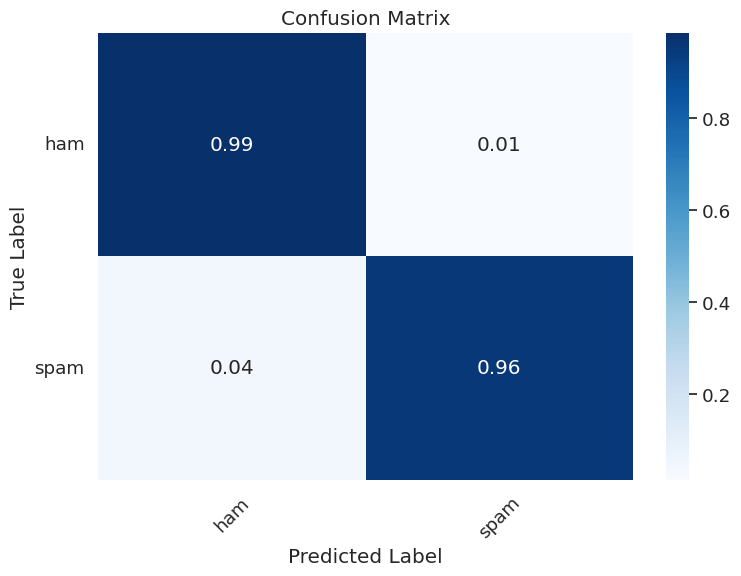

In [653]:
cm = confusion_matrix(y_val, naive_preds)
plot_confusion_matrix(cm, classes=['ham', 'spam'], normalize=True)
plt.show()

Normalized Confusion Matrix


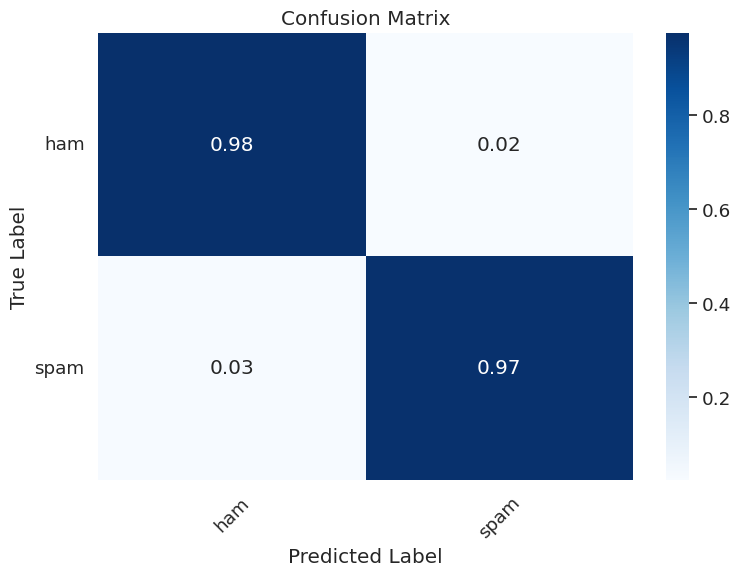

In [654]:
cm = confusion_matrix(y_test, test_preds)
plot_confusion_matrix(cm, classes=['ham', 'spam'], normalize=True)
plt.show()

### Classification report:

The model despite its simplicity has achieved truly excellent performance.

Even using randomized search to improve performance, the result remain the same.